In [1]:
%cd ../

/Users/tahaismail/Desktop/work/Baylor_Hayden/PreyPursuit


In [30]:
import dill as pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, PCA
from legacy.ChangeOfMind.functions import processing as proc
from legacy.controllers import utils as ut
import os
from legacy.PacTimeOrig.data import scripts
from pathlib import Path
from scipy.io import loadmat
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# set directories
data_dir = 'example_data'

patient_list = ['YFD']
model = 'pv'

# loadd all data
all_data_all_patients = {}
for patient in patient_list:
    path = f'{data_dir}/{patient}/all_data.pkl'
    with open(path, 'rb') as f:
        dat = pickle.load(f)
    all_data_all_patients[patient] = dat

# load tuning info
tuning_all_patients = {}
for patient in patient_list:
    path = f'{data_dir}/{patient}/tuning.pkl'
    with open(path, 'rb') as f:
        dat = pickle.load(f)
    tuning_all_patients[patient] = dat


model_thresh = 0.7
labels = ["speed", "reldist", "relspeed", "reltime", "relvalue", "wt", "wt×reward"]

total neurons: 58
  speed       : 12
  reldist     : 15
  relspeed    : 13
  reltime     : 15
  relvalue    : 15
  wt          : 14
  wt×reward   : 15


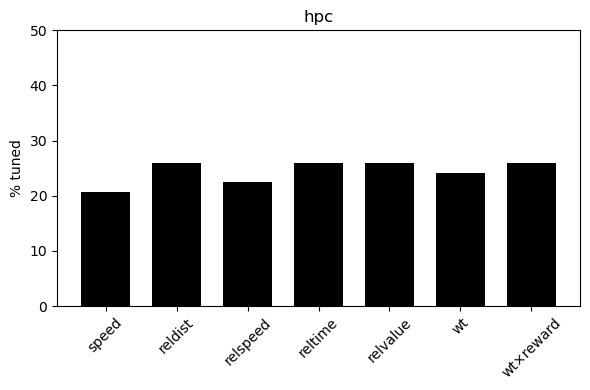

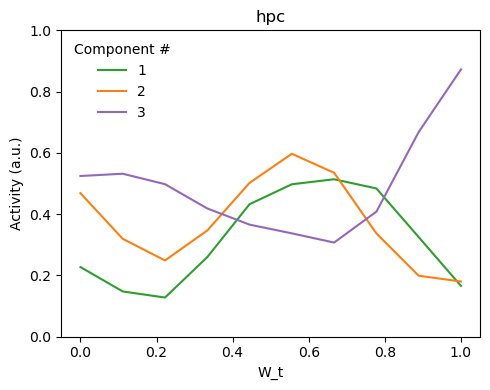

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy.ndimage import gaussian_filter1d

# -----------------------------
# 1. HPC % tuned barplot
# -----------------------------
brain_region = 'hpc'
cum_num_hpc = np.zeros(len(labels), float)
cum_den_hpc = 0

for patient in patient_list:
    df = all_data_all_patients[patient].copy()
    df["areas"] = df["areas"].replace({"cingulate": "acc"})

    good = df["model_selection"].values > model_thresh

    x1 = good & df["beta_beta_x1"].apply(lambda v: np.any(np.array(v) != 0)).values
    x2 = good & df["beta_beta_x2"].apply(lambda v: np.any(np.array(v) != 0)).values
    x3 = good & df["beta_beta_x3"].apply(lambda v: np.any(np.array(v) != 0)).values
    x4 = good & df["beta_beta_x4"].apply(lambda v: np.any(np.array(v) != 0)).values
    x6 = good & df["beta_beta_x6"].apply(lambda v: np.any(np.array(v) != 0)).values

    wt_main     = good & df["beta_beta_x5"].apply(lambda v: np.any(np.array(v) != 0)).values
    wt_x_reward = good & df["beta_tensor_x5"].apply(lambda v: np.any(np.array(v) != 0)).values

    tuned = np.column_stack([x1, x2, x3, x4, x6, wt_main, wt_x_reward])

    hpc_mask = df["areas"].eq(brain_region).values
    if hpc_mask.any():
        cum_num_hpc += tuned[hpc_mask].sum(axis=0)
        cum_den_hpc += hpc_mask.sum()

if cum_den_hpc > 0:
    print(f"total neurons: {int(cum_den_hpc)}")
    for lbl, cnt in zip(labels, cum_num_hpc.astype(int)):
        print(f"  {lbl:12s}: {cnt}")

hpc_pct = np.zeros_like(cum_num_hpc) if cum_den_hpc == 0 else 100 * (cum_num_hpc / cum_den_hpc)

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(range(len(labels)), hpc_pct, width=0.7, color='black')
ax.set_title(brain_region)
ax.set_ylabel("% tuned")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45)
ax.set_ylim(0, 50)
plt.tight_layout()
plt.show()

# -----------------------------
# 2. HPC NMF on Wt tuning
# -----------------------------
tuning_thresh = 0.7  # threshold for selecting neurons for NMF
hpc_rows = []

for patient in patient_list:
    df = all_data_all_patients[patient]
    tuning = tuning_all_patients[patient]

    mask_hpc = (df['areas'] == brain_region) & (df['model_selection'] > tuning_thresh)
    hpc_series = tuning.loc[mask_hpc, 'wt'].dropna()

    for a in hpc_series:
        a = np.asarray(a)
        if a.size == 0:
            continue
        # flatten 2 x 10 matrix -> length 20
        hpc_rows.append(a.T.ravel())

if len(hpc_rows) == 0:
    print("No HPC Wt tuning curves found for NMF.")
else:
    all_hpc_raw = np.vstack(hpc_rows)  # shape: (N_neurons, 20)
    # reshape: (N_neurons, 2, 10) and average across the 2 dimension -> (N_neurons, 10)
    all_hpc = all_hpc_raw.reshape(all_hpc_raw.shape[0], 2, 10).mean(axis=1)

    # NMF on (bins x neurons) = 10 x N
    model = NMF(n_components=5, init='random', random_state=0, l1_ratio=1)
    hpc_nmf = model.fit_transform(all_hpc.T)  # shape: (10, 5)

    n_plot = 3
    colors = ["#2ca02c", "#ff7f0e", "#9467bd"]  # green, orange, purple
    sigma = 1.2

    fig, ax = plt.subplots(figsize=(5, 4))
    x = np.linspace(0, 1, hpc_nmf.shape[0])

    for i in range(n_plot):
        comp = hpc_nmf[:, i]
        comp = (comp - comp.min()) / (comp.max() - comp.min() + 1e-9)
        comp_smooth = gaussian_filter1d(comp, sigma=sigma)
        ax.plot(x, comp_smooth, color=colors[i], label=f"{i+1}")

    ax.set_title(brain_region)
    ax.set_xlabel("W_t")
    ax.set_ylabel("Activity (a.u.)")
    ax.set_ylim([0, 1])
    ax.legend(title="Component #", frameon=False)
    plt.tight_layout()
    plt.show()


YFD: kept 138 trials (relvalue≠0)
YFD: kept 0 trials (deltarew=0)
starting permutation (relvalue≠0): 0
starting permutation (relvalue≠0): 1
starting permutation (relvalue≠0): 2
starting permutation (relvalue≠0): 3
starting permutation (relvalue≠0): 4


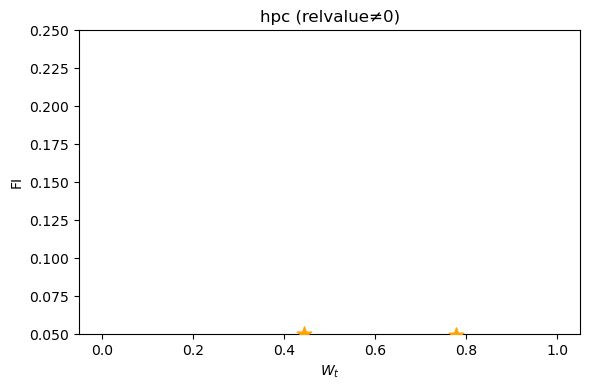

In [32]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


cfgparams = ut.generate_sim_defaults()
cfgparams['rbfs']      = 30
cfgparams['data_path'] = data_dir
cfgparams['scaling']   = 0.001
cfgparams['subjtype']  = 'emu'
cfgparams['folder']    = data_dir
cfgparams['session']   = 1
cfgparams['trialtype'] = '2'

dat = {
    "psth_sess_emu": {},
    "Xd_sess_emu": {},
    "outputs_sess_emu": {},
}
datZero = {
    "psth_sess_emu": {},
    "Xd_sess_emu": {},
    "outputs_sess_emu": {},
}

model = 'pv'

for patient in patient_list:
    cfgparams['subj'] = patient
    Xdsgn, kinematics, sessvars, psth, brainareas = scripts.human_emu_run(cfgparams)

    output_mats = loadmat(Path(data_dir) / patient / model / 'model_matrices.mat')['pt_outs']
    wt = [mat['model_shift'][0, 0][0].reshape(-1, 1) for mat in output_mats.squeeze()]

    # -------- relvalue != 0 --------
    keep_mask = [xd['relvalue'].iloc[0] != 0 for xd in Xdsgn]
    Xdsgn_keep = [xd for xd, keep in zip(Xdsgn, keep_mask) if keep]
    psth_keep  = [p  for p,  keep in zip(psth,  keep_mask) if keep]
    wt_keep    = [w  for w,  keep in zip(wt,   keep_mask) if keep]

    print(f"{patient}: kept {len(Xdsgn_keep)} trials (relvalue≠0)")

    dat["psth_sess_emu"][patient]     = (0, psth_keep)
    dat["Xd_sess_emu"][patient]       = {1: Xdsgn_keep}
    dat["outputs_sess_emu"][patient]  = {1: {'wt_per_trial': wt_keep}}

    # -------- deltarew == 0 --------
    zero_mask = [xd['relvalue'].iloc[0] == 0 for xd in Xdsgn]
    Xdsgn_zero = [xd for xd, keep in zip(Xdsgn, zero_mask) if keep]
    psth_zero  = [p  for p,  keep in zip(psth,  zero_mask) if keep]
    wt_zero    = [w  for w,  keep in zip(wt,   zero_mask) if keep]

    print(f"{patient}: kept {len(Xdsgn_zero)} trials (deltarew=0)")

    datZero["psth_sess_emu"][patient]    = (0, psth_zero)
    datZero["Xd_sess_emu"][patient]      = {1: Xdsgn_zero}
    datZero["outputs_sess_emu"][patient] = {1: {'wt_per_trial': wt_zero}}

# For the first FI analysis we need all_data (concatenated across patients)
all_data = pd.concat(all_data_all_patients.values())

# 2. FI for relvalue≠0 trials (using dat)

hpc_keep = (
    (all_data['areas'] == brain_region) &
    (all_data['beta_beta_x5'].apply(np.sum) > 0) &
    (all_data['model_selection'] > tuning_thresh)
)

FI_hpc_24 = []
null_hpc_runs_24 = []

n_perms = 5
n_boot  = 1000

if dat["psth_sess_emu"]:
    for nperm in range(n_perms):
        print("starting permutation (relvalue≠0):", nperm)
    
        all_train, all_test, means = proc.get_kfold_tuning_wt(dat)
        pca = PCA(n_components=0.9, svd_solver="full")
    
        FI_hpc_tmp = []
    
        for k in range(5):
            tmp_train = np.stack(all_train[k].iloc[np.where(hpc_keep)[0]]['fr'].values, axis=0)
            tmp_test  = np.stack(all_test[k].iloc[np.where(hpc_keep)[0]]['fr'].values, axis=0)
    
            pca.fit(tmp_train.T)
            trans = pca.transform(tmp_test.T)
            FI_hpc_tmp.append(np.diagonal(cdist(trans, trans), offset=1))
    
        FI_hpc_tmp = np.stack(FI_hpc_tmp)             # (folds, bins)
        FI_hpc_24.append(FI_hpc_tmp.mean(axis=0))     # mean over folds
    
        # permutation null
        flat = FI_hpc_tmp.ravel()
        dist_perm_temp_hpc = []
        F, M = FI_hpc_tmp.shape
        for _ in range(n_boot):
            dist_perm_temp_hpc.append(
                np.random.permutation(flat).reshape(F, M).mean(axis=0)
            )
        dist_perm_temp_hpc = np.stack(dist_perm_temp_hpc)
        null_hpc_runs_24.append(dist_perm_temp_hpc)
    
    FI_hpc_arr_24 = np.stack(FI_hpc_24)         # (n_perms, bins)
    null_hpc_stack_24 = np.stack(null_hpc_runs_24, axis=0)  # (n_perms, n_boot, bins)
    
    mu_hpc_24 = FI_hpc_arr_24.mean(axis=0)
    sd_hpc_24 = FI_hpc_arr_24.std(axis=0, ddof=1)
    
    # average null across outer repeats, then percentiles across permutations
    null_hpc_mean_over_repeats_24 = null_hpc_stack_24.mean(axis=0)  # (n_boot, bins)
    null_lo_hpc_24, null_hi_hpc_24 = np.percentile(
        null_hpc_mean_over_repeats_24, [2.5, 97.5], axis=0
    )
    
    sig_hpc_24 = mu_hpc_24 > null_hi_hpc_24
    
    x = np.linspace(0, 1, mu_hpc_24.size)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.fill_between(x, null_lo_hpc_24, null_hi_hpc_24,
                    color='lightgray', alpha=1.0, zorder=1)
    ax.fill_between(x, mu_hpc_24 - 1.64*sd_hpc_24, mu_hpc_24 + 1.64*sd_hpc_24,
                    color='#1f77b4', alpha=0.9, zorder=2)
    ax.plot(x, mu_hpc_24, 'k', zorder=3)
    
    y_star_hpc_24 = (mu_hpc_24 + 1.64*sd_hpc_24) + 0.003
    ax.scatter(x[sig_hpc_24], y_star_hpc_24[sig_hpc_24],
               marker='*', s=120, color='orange', zorder=5)
    
    ax.set_title(f"{brain_region} (relvalue≠0)")
    ax.set_xlabel(r"$W_t$")
    ax.set_ylabel("FI")
    ax.set_ylim(0.05, 0.25)
    
    plt.tight_layout()
    plt.show()

# 3. FI for deltarew=0 trials 

# prune datZero: remove patients with zero trials
for subj in list(datZero['psth_sess_emu'].keys()):
    trials = datZero['psth_sess_emu'][subj][1]
    if len(trials) == 0:
        datZero['psth_sess_emu'].pop(subj, None)
        datZero['Xd_sess_emu'].pop(subj, None)
        datZero['outputs_sess_emu'].pop(subj, None)

# order of patients used inside folds
patient_order = list(datZero['psth_sess_emu'].keys())

hpc_idx = []
offset = 0
for patient in patient_order:
    dfp = all_data_all_patients[patient].copy()
    dfp['areas'] = dfp['areas'].replace({'cingulate': 'acc'})

    tuned_x5 = (
        dfp['beta_beta_x5'].apply(lambda v: np.any(np.asarray(v) != 0)) &
        (dfp['model_selection'] > tuning_thresh)
    )

    areas = dfp['areas'].values
    n_neurons = len(areas)

    hpc_local = np.where((areas == brain_region) & tuned_x5.values)[0]
    hpc_idx.extend((hpc_local + offset).tolist())

    offset += n_neurons

FI_hpc_0 = []
null_hpc_runs_0 = []

if datZero["psth_sess_emu"]:
    for nperm in range(n_perms):
        print("starting permutation (deltarew=0):", nperm)
    
        all_train, all_test, means = proc.get_kfold_tuning_wt(datZero)
        # pca = PCA(n_components=4)
        pca = PCA(n_components=0.9, svd_solver="full")
    
        FI_hpc_tmp = []
    
        if len(hpc_idx) > 0:
            for k in range(5):
                fold_train = all_train[k].iloc[hpc_idx]
                fold_test  = all_test[k].iloc[hpc_idx]
    
                tmp_train = np.stack(fold_train['fr'].values, axis=0)
                tmp_test  = np.stack(fold_test['fr'].values, axis=0)
    
                pca.fit(tmp_train.T)
                
                trans = pca.transform(tmp_test.T)
                FI_hpc_tmp.append(np.diagonal(cdist(trans, trans), offset=1))
    
        if FI_hpc_tmp:
            FI_hpc_tmp = np.stack(FI_hpc_tmp)      # (folds, bins)
            FI_hpc_0.append(FI_hpc_tmp.mean(axis=0))
    
            # permutation null
            F, M = FI_hpc_tmp.shape
            flat = FI_hpc_tmp.ravel()
            dist_perm_temp_hpc = []
            for _ in range(n_boot):
                dist_perm_temp_hpc.append(
                    np.random.permutation(flat).reshape(F, M).mean(axis=0)
                )
            dist_perm_temp_hpc = np.stack(dist_perm_temp_hpc)
            null_hpc_runs_0.append(dist_perm_temp_hpc)
    
    # stack observed FI
    FI_hpc_arr_0 = np.stack(FI_hpc_0)              # (n_runs, bins)
    null_hpc_stack_0 = np.stack(null_hpc_runs_0, axis=0)  # (n_runs, n_boot, bins)
    
    mu_hpc_0 = FI_hpc_arr_0.mean(axis=0)
    sd_hpc_0 = FI_hpc_arr_0.std(axis=0, ddof=1)
    
    null_hpc_mean_over_repeats_0 = null_hpc_stack_0.mean(axis=0)
    null_lo_hpc_0, null_hi_hpc_0 = np.percentile(
        null_hpc_mean_over_repeats_0, [2.5, 97.5], axis=0
    )
    
    sig_hpc_0 = mu_hpc_0 > null_hi_hpc_0
    
    x = np.linspace(0, 1, mu_hpc_0.size)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.fill_between(x, null_lo_hpc_0, null_hi_hpc_0,
                    color='lightgray', alpha=1.0, zorder=1)
    ax.fill_between(x, mu_hpc_0 - 1.64*sd_hpc_0, mu_hpc_0 + 1.64*sd_hpc_0,
                    color='#1f77b4', alpha=0.9, zorder=2)
    ax.plot(x, mu_hpc_0, 'k', zorder=3)
    
    y_star_hpc_0 = (mu_hpc_0 + 1.64*sd_hpc_0) + 0.003
    ax.scatter(x[sig_hpc_0], y_star_hpc_0[sig_hpc_0],
               marker='*', s=120, color='orange', zorder=5)
    
    ax.set_title(f"{brain_region} (relvalue=0)")
    ax.set_xlabel(r"$W_t$")
    ax.set_ylabel("FI")
    ax.set_ylim(0.05, 0.25)
    
    plt.tight_layout()
    plt.show()


hpc relvalue≠0: 14 neurons
hpc Δrew = 0:  0 neurons
tuning_rel shape:  (14, 11)


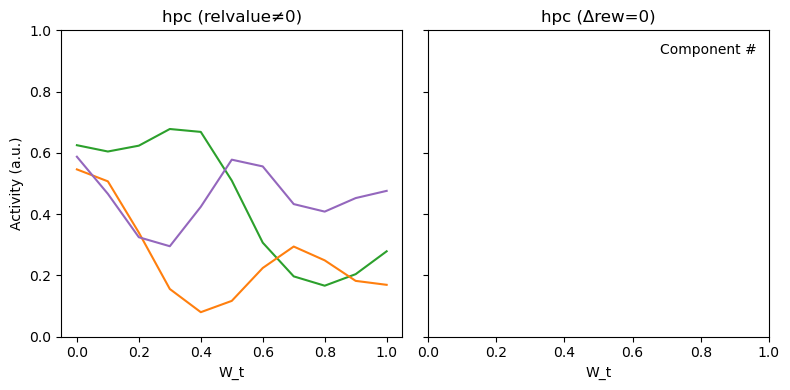

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy.ndimage import gaussian_filter1d


def build_region_idx(dat_struct, patient_list_for_dat, brain_region, tuning_thresh):
    """
    Returns: list of neuron indices (global across all patients)
             for this condition & brain region.
    """
    region_idx = []
    offset = 0

    for patient in patient_list_for_dat:
        dfp = all_data_all_patients[patient].copy()
        dfp["areas"] = dfp["areas"].replace({"cingulate": "acc"})

        tuned_x5 = (
            dfp["beta_beta_x5"].apply(lambda v: np.any(np.asarray(v) != 0)) &
            (dfp["model_selection"] > tuning_thresh)
        )

        areas = dfp["areas"].values
        n_neurons = len(areas)

        local = np.where((areas == brain_region) & tuned_x5.values)[0]
        region_idx.extend((local + offset).tolist())

        offset += n_neurons

    return np.array(region_idx, dtype=int)

# ---------------------------------------------------
# Helper: build tuning matrix for a given condition
# ---------------------------------------------------
def build_tuning_matrix(dat_struct, region_idx):
    """
    Returns: matrix (N_neurons, n_bins) of mean tuning across folds.
    """
    all_train, all_test, means = proc.get_kfold_tuning_wt(dat_struct)
    n_folds = len(all_train)

    mats = []
    for k in range(n_folds):
        fold = all_train[k].iloc[region_idx]
        fr_mat = np.stack(fold["fr"].values, axis=0)  # (N_neurons, n_bins)
        mats.append(fr_mat)

    mats = np.stack(mats, axis=0)   # (folds, N_neurons, n_bins)
    return mats.mean(axis=0)        # (N_neurons, n_bins)

# ---------------------------------------------------
# 1) Build indices separately for each condition
# ---------------------------------------------------
patient_order_rel  = list(dat["psth_sess_emu"].keys())
patient_order_zero = list(datZero["psth_sess_emu"].keys())

idx_rel  = build_region_idx(dat,     patient_order_rel,  brain_region, tuning_thresh)
idx_zero = build_region_idx(datZero, patient_order_zero, brain_region, tuning_thresh)

print(f"{brain_region} relvalue≠0: {len(idx_rel)} neurons")
print(f"{brain_region} Δrew = 0:  {len(idx_zero)} neurons")

# ---------------------------------------------------
# 2) Build tuning matrices per condition
# ---------------------------------------------------
if dat["psth_sess_emu"]:
    tuning_rel  = build_tuning_matrix(dat,     idx_rel)   # (N_rel,  n_bins)
else:
    tuning_rel = None
    
if datZero["psth_sess_emu"]:
    tuning_zero = build_tuning_matrix(datZero, idx_zero)  # (N_zero, n_bins)
else:
    tuning_zero = None

# ---------------------------------------------------
# 3) Run NMF separately for each condition
# ---------------------------------------------------

n_components = 5

if tuning_rel is not None:
    print("tuning_rel shape: ",  tuning_rel.shape)
    X_rel  = tuning_rel.T        # (n_bins, N_rel)
    model_rel  = NMF(n_components=n_components, init="random",
                 random_state=0, l1_ratio=1)
    W_rel  = model_rel.fit_transform(X_rel)      # (n_bins, n_components)

if tuning_zero is not None:
    print("tuning_zero shape:", tuning_zero.shape)
    
    
    X_zero = tuning_zero.T       # (n_bins, N_zero)
    
    
    model_zero = NMF(n_components=n_components, init="random",
                     random_state=0, l1_ratio=1)
    
    
    W_zero = model_zero.fit_transform(X_zero)    # (n_bins, n_components)

# ---------------------------------------------------
# 4) Plot components for the two conditions
# ---------------------------------------------------
def normalize(v):
    return (v - v.min()) / (v.max() - v.min() + 1e-9)  
    
n_plot = 3
colors = ["#2ca02c", "#ff7f0e", "#9467bd"]
sigma  = 1.2

n_bins = W_rel.shape[0]
x = np.linspace(0, 1, n_bins)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

for i in range(n_plot):
    # relvalue≠0
    if tuning_rel is not None:
        comp_r = normalize(W_rel[:, i])
        comp_r = gaussian_filter1d(comp_r, sigma=sigma)
        axes[0].plot(x, comp_r, color=colors[i], label=f"{i+1}")

    # Δrew = 0
    if tuning_zero is not None:
        comp_z = normalize(W_zero[:, i])
        comp_z = gaussian_filter1d(comp_z, sigma=sigma)
        axes[1].plot(x, comp_z, color=colors[i], label=f"{i+1}")

axes[0].set_title(f"{brain_region} (relvalue≠0)")
axes[1].set_title(f"{brain_region} (Δrew=0)")
axes[0].set_xlabel("W_t")
axes[1].set_xlabel("W_t")
axes[0].set_ylabel("Activity (a.u.)")
axes[0].set_ylim([0, 1])

axes[1].legend(title="Component #", frameon=False)

plt.tight_layout()
plt.show()


total neurons: 25
  speed       : 3
  reldist     : 3
  relspeed    : 3
  reltime     : 3
  relvalue    : 3
  wt          : 3
  wt×reward   : 3


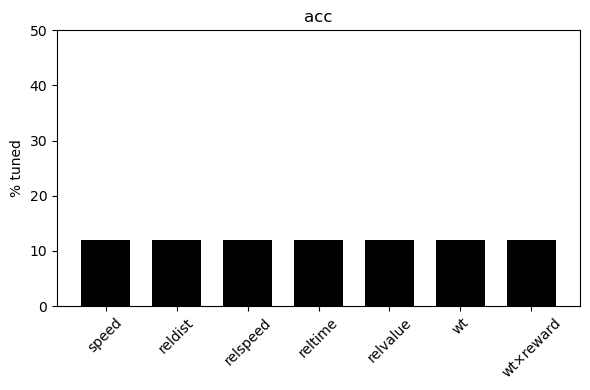

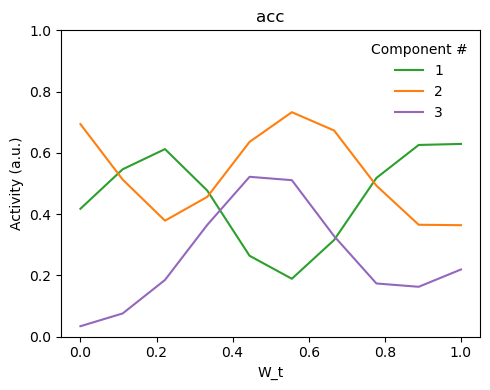

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy.ndimage import gaussian_filter1d

# -----------------------------
# 1. acc % tuned barplot
# -----------------------------
brain_region = 'acc'
cum_num_acc = np.zeros(len(labels), float)
cum_den_acc = 0

for patient in patient_list:
    df = all_data_all_patients[patient].copy()
    df["areas"] = df["areas"].replace({"cingulate": "acc"})

    good = df["model_selection"].values > model_thresh

    x1 = good & df["beta_beta_x1"].apply(lambda v: np.any(np.array(v) != 0)).values
    x2 = good & df["beta_beta_x2"].apply(lambda v: np.any(np.array(v) != 0)).values
    x3 = good & df["beta_beta_x3"].apply(lambda v: np.any(np.array(v) != 0)).values
    x4 = good & df["beta_beta_x4"].apply(lambda v: np.any(np.array(v) != 0)).values
    x6 = good & df["beta_beta_x6"].apply(lambda v: np.any(np.array(v) != 0)).values

    wt_main     = good & df["beta_beta_x5"].apply(lambda v: np.any(np.array(v) != 0)).values
    wt_x_reward = good & df["beta_tensor_x5"].apply(lambda v: np.any(np.array(v) != 0)).values

    tuned = np.column_stack([x1, x2, x3, x4, x6, wt_main, wt_x_reward])

    acc_mask = df["areas"].eq(brain_region).values
    if acc_mask.any():
        cum_num_acc += tuned[acc_mask].sum(axis=0)
        cum_den_acc += acc_mask.sum()

if cum_den_acc > 0:
    print(f"total neurons: {int(cum_den_acc)}")
    for lbl, cnt in zip(labels, cum_num_acc.astype(int)):
        print(f"  {lbl:12s}: {cnt}")

acc_pct = np.zeros_like(cum_num_acc) if cum_den_acc == 0 else 100 * (cum_num_acc / cum_den_acc)

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(range(len(labels)), acc_pct, width=0.7, color='black')
ax.set_title(brain_region)
ax.set_ylabel("% tuned")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45)
ax.set_ylim(0, 50)
plt.tight_layout()
plt.show()

# -----------------------------
# 2. acc NMF on Wt tuning
# -----------------------------
tuning_thresh = 0.7  # threshold for selecting neurons for NMF
acc_rows = []

for patient in patient_list:
    df = all_data_all_patients[patient]
    tuning = tuning_all_patients[patient]

    mask_acc = (df['areas'] == brain_region) & (df['model_selection'] > tuning_thresh)
    acc_series = tuning.loc[mask_acc, 'wt'].dropna()

    for a in acc_series:
        a = np.asarray(a)
        if a.size == 0:
            continue
        # flatten 2 x 10 matrix -> length 20
        acc_rows.append(a.T.ravel())

if len(acc_rows) == 0:
    print("No acc Wt tuning curves found for NMF.")
else:
    all_acc_raw = np.vstack(acc_rows)  # shape: (N_neurons, 20)
    # reshape: (N_neurons, 2, 10) and average across the 2 dimension -> (N_neurons, 10)
    all_acc = all_acc_raw.reshape(all_acc_raw.shape[0], 2, 10).mean(axis=1)

    # NMF on (bins x neurons) = 10 x N
    model = NMF(n_components=5, init='random', random_state=0, l1_ratio=1)
    acc_nmf = model.fit_transform(all_acc.T)  # shape: (10, 5)

    n_plot = 3
    colors = ["#2ca02c", "#ff7f0e", "#9467bd"]  # green, orange, purple
    sigma = 1.2

    fig, ax = plt.subplots(figsize=(5, 4))
    x = np.linspace(0, 1, acc_nmf.shape[0])

    for i in range(n_plot):
        comp = acc_nmf[:, i]
        comp = (comp - comp.min()) / (comp.max() - comp.min() + 1e-9)
        comp_smooth = gaussian_filter1d(comp, sigma=sigma)
        ax.plot(x, comp_smooth, color=colors[i], label=f"{i+1}")

    ax.set_title(brain_region)
    ax.set_xlabel("W_t")
    ax.set_ylabel("Activity (a.u.)")
    ax.set_ylim([0, 1])
    ax.legend(title="Component #", frameon=False)
    plt.tight_layout()
    plt.show()


YFD: kept 138 trials (relvalue≠0)
YFD: kept 0 trials (deltarew=0)
starting permutation (relvalue≠0): 0
starting permutation (relvalue≠0): 1
starting permutation (relvalue≠0): 2
starting permutation (relvalue≠0): 3
starting permutation (relvalue≠0): 4


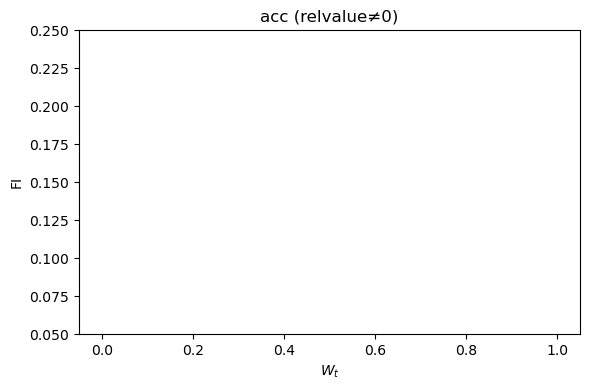

In [35]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


cfgparams = ut.generate_sim_defaults()
cfgparams['rbfs']      = 30
cfgparams['data_path'] = data_dir
cfgparams['scaling']   = 0.001
cfgparams['subjtype']  = 'emu'
cfgparams['folder']    = data_dir
cfgparams['session']   = 1
cfgparams['trialtype'] = '2'

dat = {
    "psth_sess_emu": {},
    "Xd_sess_emu": {},
    "outputs_sess_emu": {},
}
datZero = {
    "psth_sess_emu": {},
    "Xd_sess_emu": {},
    "outputs_sess_emu": {},
}

model = 'pv'

for patient in patient_list:
    cfgparams['subj'] = patient
    Xdsgn, kinematics, sessvars, psth, brainareas = scripts.human_emu_run(cfgparams)

    output_mats = loadmat(Path(data_dir) / patient / model / 'model_matrices.mat')['pt_outs']
    wt = [mat['model_shift'][0, 0][0].reshape(-1, 1) for mat in output_mats.squeeze()]

    # -------- relvalue != 0 --------
    keep_mask = [xd['relvalue'].iloc[0] != 0 for xd in Xdsgn]
    Xdsgn_keep = [xd for xd, keep in zip(Xdsgn, keep_mask) if keep]
    psth_keep  = [p  for p,  keep in zip(psth,  keep_mask) if keep]
    wt_keep    = [w  for w,  keep in zip(wt,   keep_mask) if keep]

    print(f"{patient}: kept {len(Xdsgn_keep)} trials (relvalue≠0)")

    dat["psth_sess_emu"][patient]     = (0, psth_keep)
    dat["Xd_sess_emu"][patient]       = {1: Xdsgn_keep}
    dat["outputs_sess_emu"][patient]  = {1: {'wt_per_trial': wt_keep}}

    # -------- deltarew == 0 --------
    zero_mask = [xd['relvalue'].iloc[0] == 0 for xd in Xdsgn]
    Xdsgn_zero = [xd for xd, keep in zip(Xdsgn, zero_mask) if keep]
    psth_zero  = [p  for p,  keep in zip(psth,  zero_mask) if keep]
    wt_zero    = [w  for w,  keep in zip(wt,   zero_mask) if keep]

    print(f"{patient}: kept {len(Xdsgn_zero)} trials (deltarew=0)")

    datZero["psth_sess_emu"][patient]    = (0, psth_zero)
    datZero["Xd_sess_emu"][patient]      = {1: Xdsgn_zero}
    datZero["outputs_sess_emu"][patient] = {1: {'wt_per_trial': wt_zero}}

# For the first FI analysis we need all_data (concatenated across patients)
all_data = pd.concat(all_data_all_patients.values())

# 2. FI for relvalue≠0 trials (using dat)

acc_keep = (
    (all_data['areas'] == brain_region) &
    (all_data['beta_beta_x5'].apply(np.sum) > 0) &
    (all_data['model_selection'] > tuning_thresh)
)

FI_acc_24 = []
null_acc_runs_24 = []

n_perms = 5
n_boot  = 1000

if dat["psth_sess_emu"]:
    for nperm in range(n_perms):
        print("starting permutation (relvalue≠0):", nperm)
    
        all_train, all_test, means = proc.get_kfold_tuning_wt(dat)
        pca = PCA(n_components=0.9, svd_solver="full")
    
        FI_acc_tmp = []
    
        for k in range(5):
            tmp_train = np.stack(all_train[k].iloc[np.where(acc_keep)[0]]['fr'].values, axis=0)
            tmp_test  = np.stack(all_test[k].iloc[np.where(acc_keep)[0]]['fr'].values, axis=0)
    
            pca.fit(tmp_train.T)
            trans = pca.transform(tmp_test.T)
            FI_acc_tmp.append(np.diagonal(cdist(trans, trans), offset=1))
    
        FI_acc_tmp = np.stack(FI_acc_tmp)             # (folds, bins)
        FI_acc_24.append(FI_acc_tmp.mean(axis=0))     # mean over folds
    
        # permutation null
        flat = FI_acc_tmp.ravel()
        dist_perm_temp_acc = []
        F, M = FI_acc_tmp.shape
        for _ in range(n_boot):
            dist_perm_temp_acc.append(
                np.random.permutation(flat).reshape(F, M).mean(axis=0)
            )
        dist_perm_temp_acc = np.stack(dist_perm_temp_acc)
        null_acc_runs_24.append(dist_perm_temp_acc)
    
    FI_acc_arr_24 = np.stack(FI_acc_24)         # (n_perms, bins)
    null_acc_stack_24 = np.stack(null_acc_runs_24, axis=0)  # (n_perms, n_boot, bins)
    
    mu_acc_24 = FI_acc_arr_24.mean(axis=0)
    sd_acc_24 = FI_acc_arr_24.std(axis=0, ddof=1)
    
    # average null across outer repeats, then percentiles across permutations
    null_acc_mean_over_repeats_24 = null_acc_stack_24.mean(axis=0)  # (n_boot, bins)
    null_lo_acc_24, null_hi_acc_24 = np.percentile(
        null_acc_mean_over_repeats_24, [2.5, 97.5], axis=0
    )
    
    sig_acc_24 = mu_acc_24 > null_hi_acc_24
    
    x = np.linspace(0, 1, mu_acc_24.size)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.fill_between(x, null_lo_acc_24, null_hi_acc_24,
                    color='lightgray', alpha=1.0, zorder=1)
    ax.fill_between(x, mu_acc_24 - 1.64*sd_acc_24, mu_acc_24 + 1.64*sd_acc_24,
                    color='#1f77b4', alpha=0.9, zorder=2)
    ax.plot(x, mu_acc_24, 'k', zorder=3)
    
    y_star_acc_24 = (mu_acc_24 + 1.64*sd_acc_24) + 0.003
    ax.scatter(x[sig_acc_24], y_star_acc_24[sig_acc_24],
               marker='*', s=120, color='orange', zorder=5)
    
    ax.set_title(f"{brain_region} (relvalue≠0)")
    ax.set_xlabel(r"$W_t$")
    ax.set_ylabel("FI")
    ax.set_ylim(0.05, 0.25)
    
    plt.tight_layout()
    plt.show()

# 3. FI for deltarew=0 trials 

# prune datZero: remove patients with zero trials
for subj in list(datZero['psth_sess_emu'].keys()):
    trials = datZero['psth_sess_emu'][subj][1]
    if len(trials) == 0:
        datZero['psth_sess_emu'].pop(subj, None)
        datZero['Xd_sess_emu'].pop(subj, None)
        datZero['outputs_sess_emu'].pop(subj, None)

# order of patients used inside folds
patient_order = list(datZero['psth_sess_emu'].keys())

acc_idx = []
offset = 0
for patient in patient_order:
    dfp = all_data_all_patients[patient].copy()
    dfp['areas'] = dfp['areas'].replace({'cingulate': 'acc'})

    tuned_x5 = (
        dfp['beta_beta_x5'].apply(lambda v: np.any(np.asarray(v) != 0)) &
        (dfp['model_selection'] > tuning_thresh)
    )

    areas = dfp['areas'].values
    n_neurons = len(areas)

    acc_local = np.where((areas == brain_region) & tuned_x5.values)[0]
    acc_idx.extend((acc_local + offset).tolist())

    offset += n_neurons

FI_acc_0 = []
null_acc_runs_0 = []

if datZero["psth_sess_emu"]:
    for nperm in range(n_perms):
        print("starting permutation (deltarew=0):", nperm)
    
        all_train, all_test, means = proc.get_kfold_tuning_wt(datZero)
        # pca = PCA(n_components=4)
        pca = PCA(n_components=0.9, svd_solver="full")
    
        FI_acc_tmp = []
    
        if len(acc_idx) > 0:
            for k in range(5):
                fold_train = all_train[k].iloc[acc_idx]
                fold_test  = all_test[k].iloc[acc_idx]
    
                tmp_train = np.stack(fold_train['fr'].values, axis=0)
                tmp_test  = np.stack(fold_test['fr'].values, axis=0)
    
                pca.fit(tmp_train.T)
                
                trans = pca.transform(tmp_test.T)
                FI_acc_tmp.append(np.diagonal(cdist(trans, trans), offset=1))
    
        if FI_acc_tmp:
            FI_acc_tmp = np.stack(FI_acc_tmp)      # (folds, bins)
            FI_acc_0.append(FI_acc_tmp.mean(axis=0))
    
            # permutation null
            F, M = FI_acc_tmp.shape
            flat = FI_acc_tmp.ravel()
            dist_perm_temp_acc = []
            for _ in range(n_boot):
                dist_perm_temp_acc.append(
                    np.random.permutation(flat).reshape(F, M).mean(axis=0)
                )
            dist_perm_temp_acc = np.stack(dist_perm_temp_acc)
            null_acc_runs_0.append(dist_perm_temp_acc)
    
    # stack observed FI
    FI_acc_arr_0 = np.stack(FI_acc_0)              # (n_runs, bins)
    null_acc_stack_0 = np.stack(null_acc_runs_0, axis=0)  # (n_runs, n_boot, bins)
    
    mu_acc_0 = FI_acc_arr_0.mean(axis=0)
    sd_acc_0 = FI_acc_arr_0.std(axis=0, ddof=1)
    
    null_acc_mean_over_repeats_0 = null_acc_stack_0.mean(axis=0)
    null_lo_acc_0, null_hi_acc_0 = np.percentile(
        null_acc_mean_over_repeats_0, [2.5, 97.5], axis=0
    )
    
    sig_acc_0 = mu_acc_0 > null_hi_acc_0
    
    x = np.linspace(0, 1, mu_acc_0.size)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.fill_between(x, null_lo_acc_0, null_hi_acc_0,
                    color='lightgray', alpha=1.0, zorder=1)
    ax.fill_between(x, mu_acc_0 - 1.64*sd_acc_0, mu_acc_0 + 1.64*sd_acc_0,
                    color='#1f77b4', alpha=0.9, zorder=2)
    ax.plot(x, mu_acc_0, 'k', zorder=3)
    
    y_star_acc_0 = (mu_acc_0 + 1.64*sd_acc_0) + 0.003
    ax.scatter(x[sig_acc_0], y_star_acc_0[sig_acc_0],
               marker='*', s=120, color='orange', zorder=5)
    
    ax.set_title(f"{brain_region} (relvalue=0)")
    ax.set_xlabel(r"$W_t$")
    ax.set_ylabel("FI")
    ax.set_ylim(0.05, 0.25)
    
    plt.tight_layout()
    plt.show()


acc relvalue≠0: 3 neurons
acc Δrew = 0:  0 neurons
tuning_rel shape:  (3, 11)


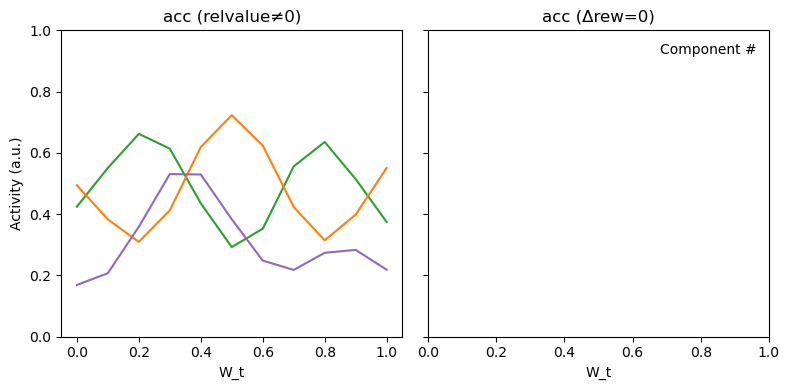

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy.ndimage import gaussian_filter1d


def build_region_idx(dat_struct, patient_list_for_dat, brain_region, tuning_thresh):
    """
    Returns: list of neuron indices (global across all patients)
             for this condition & brain region.
    """
    region_idx = []
    offset = 0

    for patient in patient_list_for_dat:
        dfp = all_data_all_patients[patient].copy()
        dfp["areas"] = dfp["areas"].replace({"cingulate": "acc"})

        tuned_x5 = (
            dfp["beta_beta_x5"].apply(lambda v: np.any(np.asarray(v) != 0)) &
            (dfp["model_selection"] > tuning_thresh)
        )

        areas = dfp["areas"].values
        n_neurons = len(areas)

        local = np.where((areas == brain_region) & tuned_x5.values)[0]
        region_idx.extend((local + offset).tolist())

        offset += n_neurons

    return np.array(region_idx, dtype=int)

# ---------------------------------------------------
# Helper: build tuning matrix for a given condition
# ---------------------------------------------------
def build_tuning_matrix(dat_struct, region_idx):
    """
    Returns: matrix (N_neurons, n_bins) of mean tuning across folds.
    """
    all_train, all_test, means = proc.get_kfold_tuning_wt(dat_struct)
    n_folds = len(all_train)

    mats = []
    for k in range(n_folds):
        fold = all_train[k].iloc[region_idx]
        fr_mat = np.stack(fold["fr"].values, axis=0)  # (N_neurons, n_bins)
        mats.append(fr_mat)

    mats = np.stack(mats, axis=0)   # (folds, N_neurons, n_bins)
    return mats.mean(axis=0)        # (N_neurons, n_bins)

# ---------------------------------------------------
# 1) Build indices separately for each condition
# ---------------------------------------------------
patient_order_rel  = list(dat["psth_sess_emu"].keys())
patient_order_zero = list(datZero["psth_sess_emu"].keys())

idx_rel  = build_region_idx(dat,     patient_order_rel,  brain_region, tuning_thresh)
idx_zero = build_region_idx(datZero, patient_order_zero, brain_region, tuning_thresh)

print(f"{brain_region} relvalue≠0: {len(idx_rel)} neurons")
print(f"{brain_region} Δrew = 0:  {len(idx_zero)} neurons")

# ---------------------------------------------------
# 2) Build tuning matrices per condition
# ---------------------------------------------------
if dat["psth_sess_emu"]:
    tuning_rel  = build_tuning_matrix(dat,     idx_rel)   # (N_rel,  n_bins)
else:
    tuning_rel = None
    
if datZero["psth_sess_emu"]:
    tuning_zero = build_tuning_matrix(datZero, idx_zero)  # (N_zero, n_bins)
else:
    tuning_zero = None

# ---------------------------------------------------
# 3) Run NMF separately for each condition
# ---------------------------------------------------

n_components = 5

if tuning_rel is not None:
    print("tuning_rel shape: ",  tuning_rel.shape)
    X_rel  = tuning_rel.T        # (n_bins, N_rel)
    model_rel  = NMF(n_components=n_components, init="random",
                 random_state=0, l1_ratio=1)
    W_rel  = model_rel.fit_transform(X_rel)      # (n_bins, n_components)

if tuning_zero is not None:
    print("tuning_zero shape:", tuning_zero.shape)
    
    
    X_zero = tuning_zero.T       # (n_bins, N_zero)
    
    
    model_zero = NMF(n_components=n_components, init="random",
                     random_state=0, l1_ratio=1)
    
    
    W_zero = model_zero.fit_transform(X_zero)    # (n_bins, n_components)

# ---------------------------------------------------
# 4) Plot components for the two conditions
# ---------------------------------------------------
def normalize(v):
    return (v - v.min()) / (v.max() - v.min() + 1e-9)  
    
n_plot = 3
colors = ["#2ca02c", "#ff7f0e", "#9467bd"]
sigma  = 1.2

n_bins = W_rel.shape[0]
x = np.linspace(0, 1, n_bins)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

for i in range(n_plot):
    # relvalue≠0
    if tuning_rel is not None:
        comp_r = normalize(W_rel[:, i])
        comp_r = gaussian_filter1d(comp_r, sigma=sigma)
        axes[0].plot(x, comp_r, color=colors[i], label=f"{i+1}")

    # Δrew = 0
    if tuning_zero is not None:
        comp_z = normalize(W_zero[:, i])
        comp_z = gaussian_filter1d(comp_z, sigma=sigma)
        axes[1].plot(x, comp_z, color=colors[i], label=f"{i+1}")

axes[0].set_title(f"{brain_region} (relvalue≠0)")
axes[1].set_title(f"{brain_region} (Δrew=0)")
axes[0].set_xlabel("W_t")
axes[1].set_xlabel("W_t")
axes[0].set_ylabel("Activity (a.u.)")
axes[0].set_ylim([0, 1])

axes[1].legend(title="Component #", frameon=False)

plt.tight_layout()
plt.show()
